# Enoncé

Vous avez participé à une compétition sur Kaggle sur le jeu de données de Titanic (celle-ci existe, les curieux peuvent la retrouver sur Kaggle !). Vous avez pour cela à votre disposition [une liste de 891 passagers](https://www.kaggle.com/c/titanic), contenant les caractéristiques suivantes :


- PassengerID : Identifiant du passager
- Survived : Indicateur de survi d'un passager (1 si le passager a survecu, 0 s’il est décédé)
- Pclass: Classe du passager (1 = 1ère classe, 2 = 2ème classe, 3 = 3ème classe)
- Name : Nom et titre du passager
- Sex : Sexe du passager
- Age : Age du passager (Décimal si inférieur à 1, estimé si de la forme xx.5)
- SibSp : Nombre d’époux, de frères et de soeurs présents à bord
- Parch : Nombre de parents ou d’enfants présents à bord 
- Ticket : Numéro du ticket 
- Fare : Tarif des tickets (Le prix est indiqué en £ et pour un seul achat (peut correspondre à plusieurs tickets)
- Cabin : Numéro de Cabine
- Embarked : Port d’embarcation (C = Cherbourg, Q = Queenstown, S = Southampton)
	 	

# Exercice

La compétition a été l’occasion de revenir sur ce jeu de données très célèbre, et plusieurs tâches étaient attendues, :
- identifier les facteurs favorisants la survie d'un passager par rapport à un autre, en dressant une typologie des survivants
- créer un algorithme qui pourrait prédire la survie d'un individu à partir de ces caractéristiques.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn import decomposition, preprocessing
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from os import getcwd
from function import *

## 1. Charger vos données dans un DataFrame Pandas

In [2]:
# ---------------------------------------------------------------------------------------------
#                               MAIN
# ---------------------------------------------------------------------------------------------
verbose = False
verboseMain = False

print("Chargement des données...")
# Récupère le répertoire du programme
file_path = getcwd() + "\\"

Chargement des données...


In [3]:
file_name = 'titanic_dataset.csv'
df_origin = pd.read_csv(file_path+file_name, sep=',', index_col="PassengerId")
print("Chargement des données", df_origin.shape, ".... ...................................... END")

Chargement des données (891, 11) .... ...................................... END


In [4]:
df_origin.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df = df_origin.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [6]:
df.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

Ces cabines étaient répartis entre les ponts A et E pour les 1ère classe, et de D à G pour les autres.
La cabine T est une cabine de classe supérieure située sur le pont A.

Si on observe rapidement la variable Cabin, on peut noter que le première caractère correspond au pont en question. On extrait donc ce dernier et on analyse la répartition des classes au sein des valeurs manquantes sur notre pont.

In [7]:
df['Deck']= df['Cabin'].str[0] 
df.loc[df['Deck'] == 'T', 'Deck'] = 'A'
print(df['Deck'].isnull().sum())

687


In [8]:
df.loc[df['Deck'].isnull(), 'Pclass'].value_counts()

3    479
2    168
1     40
Name: Pclass, dtype: int64

on retrouve une majorité de 2ème et 3ème classe sans cabine, on peut leur attribuer la valeur N qui correspondra à l'absence d'attribution
Pour les 1ères classes restantes, on utilisera la moyenne payée par leurs homologues en fonction de leur pont attribué et de leur pont d'embarcation

In [9]:
df.loc[(df['Deck'].isnull()) & (df['Pclass'].isin([2,3])), 'Deck'] = 'N'
print(df['Deck'].isnull().sum())

40


In [10]:
prixDeck = df.loc[df['Pclass']==1, ['Deck', 'Embarked', 'Fare']].groupby(['Deck', 'Embarked']).mean().reset_index()
prixDeck = prixDeck.sort_values('Fare', ascending=False)
print(prixDeck.shape)
prixDeck

(11, 3)


,Deck,Embarked,Fare
2,B,C,145.964018
6,C,S,101.630442
4,C,C,98.582533
9,E,C,92.905840
5,C,Q,90.000000
7,D,C,85.586000
3,B,S,85.372283
8,D,S,49.719906
10,E,S,46.448750
1,A,S,40.150456


A partir u tableau ci-dessus, on attribue à chaque personne le pont ayant le tarif le plus proche de celui qu'elle a payé, en fonction de l'endroit de son port d'embarcation.

In [11]:
prixDeck['Embarked'].value_counts()

C    5
S    5
Q    1
Name: Embarked, dtype: int64

In [12]:
mask = df['Deck'].isnull()
df.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'Deck'],
      dtype='object')

In [13]:
def get_closest(Fare, Embarked, prixDeck_df):
    prixDeck = prixDeck_df.loc[prixDeck_df['Embarked'] == Embarked,:]
    return prixDeck.loc[prixDeck['Fare'].sub(Fare).abs().idxmin(), 'Deck']

In [14]:
df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
Deck         40
dtype: int64

In [15]:
df.loc[mask, 'Deck'] = df.loc[mask, :].apply(lambda x: get_closest(x['Fare'], x['Embarked'], prixDeck), axis=1)
print(df['Deck'].isnull().sum())

0


In [16]:
df.loc[df['Embarked'].isnull(),:]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck
PassengerId,,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,B
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,B


En faisant une analyse rapide des personnes dont il manque le port d'embarcation et en utilisant le tableau prixDeck, étant toutes les 2 de classes 1 et étant sur le pont B, on peut décemment supposer qu'elles ont embarqué à Southampton (S)

In [17]:
df.loc[df['Embarked'].isnull(),'Embarked'] = 'S'

In [18]:
df.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      0
Deck          0
dtype: int64

Age étant la première variable comportant des valeurs manquantes, on peut envisager une régression linéaire pour remplacer ces valeurs manquantes, en utilisant l'ensemble des autres informations. Il faut cependant d'abord retirer les variables que nous n'utiliserons pas ou plus (ID, Name, Ticket, Cabin)

In [19]:
df_full = df.copy()

In [20]:
df = df.drop(columns=['Name', 'Ticket', 'Cabin'])
df.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'Deck'],
      dtype='object')

In [21]:
df.dtypes

Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
Deck         object
dtype: object

In [22]:
df['Sex'] = df['Sex'].astype('category')
df['Embarked'] = df['Embarked'].astype('category')
df['Deck'] = df['Deck'].astype('category')
#df['pont_cod'] = df['pont'].cat.codes
df.dtypes

Survived       int64
Pclass         int64
Sex         category
Age          float64
SibSp          int64
Parch          int64
Fare         float64
Embarked    category
Deck        category
dtype: object

On complète ensuite la varible Age

In [23]:
mask = df['Age'].notnull()

lr = smf.ols(formula="Age ~ Survived + Pclass + Sex + SibSp + Parch + Fare + Embarked + Deck", data=df.loc[mask, :]).fit()

In [24]:
df.loc[~mask, 'Age'] = round(lr.predict(df.loc[~mask,:].drop(columns=['Age'])), 0)
df.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
Deck        0
dtype: int64

# 2. Typage des données

In [9]:
df.dtypes

Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [10]:
df['Sex'] = df['Sex'].astype('category')
df['sex_cat'] = df['Sex'].cat.codes
df['sex_cat']

PassengerId
1      1
2      0
3      0
4      0
5      1
      ..
887    1
888    0
889    0
890    1
891    1
Name: sex_cat, Length: 891, dtype: int8

In [11]:
df.dtypes

Survived       int64
Pclass         int64
Name          object
Sex         category
Age          float64
SibSp          int64
Parch          int64
Ticket        object
Fare         float64
Cabin         object
Embarked      object
sex_cat         int8
dtype: object

# 3. Nettoyer votre Dataset avec drop(), dropna() 

CORR ------------------
          Survived    Pclass       Age     SibSp     Parch      Fare   sex_cat
Survived  1.000000 -0.338481 -0.077221 -0.035322  0.081629  0.257307 -0.543351
Pclass   -0.338481  1.000000 -0.369226  0.083081  0.018443 -0.549500  0.131900
Age      -0.077221 -0.369226  1.000000 -0.308247 -0.189119  0.096067  0.093254
SibSp    -0.035322  0.083081 -0.308247  1.000000  0.414838  0.159651 -0.114631
Parch     0.081629  0.018443 -0.189119  0.414838  1.000000  0.216225 -0.245489
Fare      0.257307 -0.549500  0.096067  0.159651  0.216225  1.000000 -0.182333
sex_cat  -0.543351  0.131900  0.093254 -0.114631 -0.245489 -0.182333  1.000000 



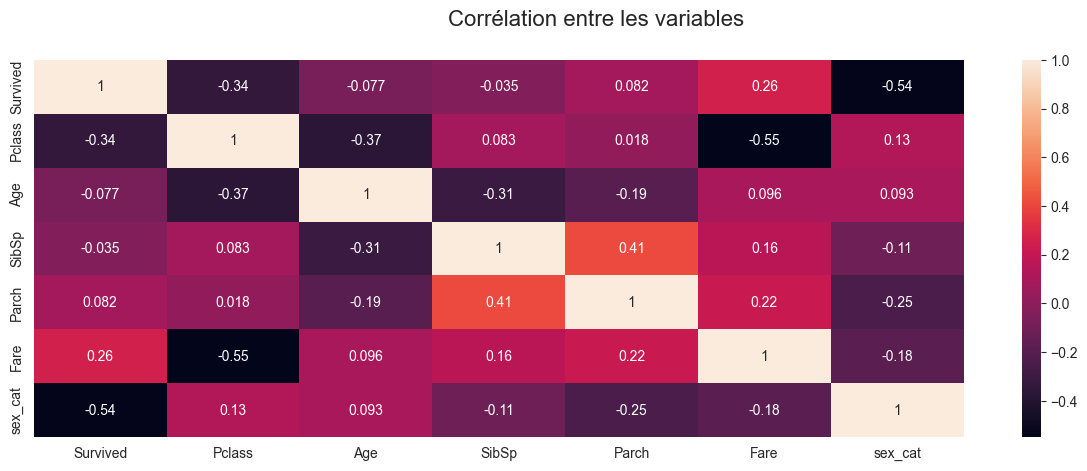

In [12]:
##on utilise data.corr et le heatmap de seborn
corr_df = df.corr()
print("CORR ------------------")
print(corr_df, "\n")
figure, ax = color_graph_background(1,1)
figure.set_size_inches(15, 5, forward=True)
figure.set_dpi(100)
figure.suptitle("Corrélation entre les variables", fontsize=16)
sns.heatmap(corr_df, annot=True)
plt.show()

## 3.1. PONT > traiter les ponts

### 3.1.1. PONT > déterminer le pont à partir de la cabine

Compléter les cabines pour les valeurs manquantes


De nombreuses valeurs manquantes parsèment le jeu de données.
Le nombre sur **Cabin** peut potentiellement facilement s'expliquer assez facilement : cela correspond pour une grande partie à des individus qui n'avaient simplement pas de cabine. En effet seuls les passagers de 1ère classe et certains de 2ème disposaient d'un numéro de cabine pour leur voyage.

Ces cabines étaient répartis entre les ponts A et E pour les 1ère classe, et de D à G pour les autres.
La cabine T est une cabine de classe supérieure située sur le pont A.

Si on observe rapidement la variable Cabin, on peut noter que le première caractère correspond au pont en question. On extrait donc ce dernier et on analyse la répartition des classes au sein des valeurs manquantes sur notre pont.

In [13]:
df['Cabin']

PassengerId
1       NaN
2       C85
3       NaN
4      C123
5       NaN
       ... 
887     NaN
888     B42
889     NaN
890    C148
891     NaN
Name: Cabin, Length: 891, dtype: object

In [16]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,sex_cat,pont
PassengerId,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,NaN
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,NaN
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,C
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,NaN


In [17]:
df.describe(include="all")

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,sex_cat,pont
count,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889,891.000000,204
unique,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3,NaN,7
top,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S,NaN,C
freq,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644,NaN,59
mean,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN,0.647587,NaN
std,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN,0.477990,NaN
min,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000,NaN
25%,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN,0.000000,NaN
50%,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN,1.000000,NaN
75%,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN,1.000000,NaN


### 3.1.2. PONT > Traiter les pont inconnus

In [18]:
df["price"] = round(df["Fare"], 0)
df["price"]

PassengerId
1       7.0
2      71.0
3       8.0
4      53.0
5       8.0
       ... 
887    13.0
888    30.0
889    23.0
890    30.0
891     8.0
Name: price, Length: 891, dtype: float64

In [19]:
pont_group = df.groupby(by=["Pclass", "Survived", "Embarked", "price"])["pont"].value_counts()
print(pont_group.shape)
pont_group

(142,)


Pclass  Survived  Embarked  price  pont
1       0         C         28.0   C       1
                            29.0   C       1
                            30.0   B       1
                                   C       1
                            31.0   A       1
                                          ..
3       0         S         10.0   G       2
        1         C         22.0   F       1
                  S         8.0    E       1
                            12.0   E       2
                            17.0   G       2
Name: pont, Length: 142, dtype: int64

### 3.1.2. PONT > Traiter les pont inconnus

In [20]:
pont_group.index

MultiIndex([(1, 0, 'C',  28.0, 'C'),
            (1, 0, 'C',  29.0, 'C'),
            (1, 0, 'C',  30.0, 'B'),
            (1, 0, 'C',  30.0, 'C'),
            (1, 0, 'C',  31.0, 'A'),
            (1, 0, 'C',  35.0, 'A'),
            (1, 0, 'C',  40.0, 'A'),
            (1, 0, 'C',  62.0, 'B'),
            (1, 0, 'C',  79.0, 'B'),
            (1, 0, 'C', 106.0, 'C'),
            ...
            (2, 1, 'S',  13.0, 'F'),
            (2, 1, 'S',  26.0, 'F'),
            (2, 1, 'S',  39.0, 'F'),
            (3, 0, 'Q',   8.0, 'F'),
            (3, 0, 'S',   8.0, 'F'),
            (3, 0, 'S',  10.0, 'G'),
            (3, 1, 'C',  22.0, 'F'),
            (3, 1, 'S',   8.0, 'E'),
            (3, 1, 'S',  12.0, 'E'),
            (3, 1, 'S',  17.0, 'G')],
           names=['Pclass', 'Survived', 'Embarked', 'price', 'pont'], length=142)

In [21]:
pont_group = pont_group.rename("nb_ponts")
# On veut préciser le pont qui a le plus de valeurs
pont_group.sort_values(ascending=False)
pont_group.head()

Pclass  Survived  Embarked  price  pont
1       0         C         28.0   C       1
                            29.0   C       1
                            30.0   B       1
                                   C       1
                            31.0   A       1
Name: nb_ponts, dtype: int64

In [22]:
# 142 rows × 6 columns
pont_group_no_index = pont_group.reset_index()
pont_group_no_index = pont_group_no_index.drop_duplicates(["Pclass","Survived","Embarked","price"], keep='first')
pont_group_no_index = pont_group_no_index[["Pclass","Survived","Embarked","price", "pont"]]
pont_group_no_index = pont_group_no_index.rename(columns={"pont":"ponts_y"})
pont_group_no_index

,Pclass,Survived,Embarked,price,ponts_y
0,1,0,C,28.0,C
1,1,0,C,29.0,C
2,1,0,C,30.0,B
4,1,0,C,31.0,A
5,1,0,C,35.0,A
...,...,...,...,...,...
137,3,0,S,10.0,G
138,3,1,C,22.0,F
139,3,1,S,8.0,E
140,3,1,S,12.0,E


In [23]:
# on merge les 2
df_global = df.merge(pont_group_no_index, on=["Pclass","Survived","Embarked","price"], how='outer', indicator=True)
df_global

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,sex_cat,pont,price,ponts_y,_merge
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,NaN,7.0,NaN,left_only
1,0,3,"Coxon, Mr. Daniel",male,59.0,0,0,364500,7.2500,NaN,S,1,NaN,7.0,NaN,left_only
2,0,3,"Ekstrom, Mr. Johan",male,45.0,0,0,347061,6.9750,NaN,S,1,NaN,7.0,NaN,left_only
3,0,3,"Coelho, Mr. Domingos Fernandeo",male,20.0,0,0,SOTON/O.Q. 3101307,7.0500,NaN,S,1,NaN,7.0,NaN,left_only
4,0,3,"Olsen, Mr. Ole Martin",male,NaN,0,0,Fa 265302,7.3125,NaN,S,1,NaN,7.0,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,"Harper, Rev. John",male,28.0,0,1,248727,33.0000,NaN,S,1,NaN,33.0,NaN,left_only
887,1,1,"Lines, Miss. Mary Conover",female,16.0,0,1,PC 17592,39.4000,D28,S,0,D,39.0,D,both
888,0,1,"Carlsson, Mr. Frans Olof",male,33.0,0,0,695,5.0000,B51 B53 B55,S,1,B,5.0,B,both
889,1,2,"Abelson, Mrs. Samuel (Hannah Wizosky)",female,28.0,1,0,P/PP 3381,24.0000,NaN,C,0,NaN,24.0,NaN,left_only


In [24]:
df_global["_merge"].value_counts()

both          489
left_only     402
right_only      0
Name: _merge, dtype: int64

In [25]:
df_global["ponts_y"].value_counts()

F    204
C     81
E     66
B     49
D     45
A     26
G     18
Name: ponts_y, dtype: int64

In [26]:
df_global["pont"].value_counts()

C    59
B    47
D    33
E    32
A    16
F    13
G     4
Name: pont, dtype: int64

In [27]:
print(df_global['ponts_y'].isna().sum())
df_global['ponts_y'] = df_global['ponts_y'].fillna("F")
df_global['ponts_y'].isna().sum()

402


0

In [28]:
df_global['pont_merge'] = df_global['pont']
df_global['pont_merge'] = df_global['pont_merge'].fillna(df_global['ponts_y'])
df_global

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,sex_cat,pont,price,ponts_y,_merge,pont_merge
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,NaN,7.0,F,left_only,F
1,0,3,"Coxon, Mr. Daniel",male,59.0,0,0,364500,7.2500,NaN,S,1,NaN,7.0,F,left_only,F
2,0,3,"Ekstrom, Mr. Johan",male,45.0,0,0,347061,6.9750,NaN,S,1,NaN,7.0,F,left_only,F
3,0,3,"Coelho, Mr. Domingos Fernandeo",male,20.0,0,0,SOTON/O.Q. 3101307,7.0500,NaN,S,1,NaN,7.0,F,left_only,F
4,0,3,"Olsen, Mr. Ole Martin",male,NaN,0,0,Fa 265302,7.3125,NaN,S,1,NaN,7.0,F,left_only,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,"Harper, Rev. John",male,28.0,0,1,248727,33.0000,NaN,S,1,NaN,33.0,F,left_only,F
887,1,1,"Lines, Miss. Mary Conover",female,16.0,0,1,PC 17592,39.4000,D28,S,0,D,39.0,D,both,D
888,0,1,"Carlsson, Mr. Frans Olof",male,33.0,0,0,695,5.0000,B51 B53 B55,S,1,B,5.0,B,both,B
889,1,2,"Abelson, Mrs. Samuel (Hannah Wizosky)",female,28.0,1,0,P/PP 3381,24.0000,NaN,C,0,NaN,24.0,F,left_only,F


In [29]:
df_global["pont_merge"].value_counts()

F    604
C     74
E     74
B     51
D     48
A     22
G     18
Name: pont_merge, dtype: int64

In [30]:
df_global[((df_global["pont_merge"] != df_global["pont"]) & (df_global["pont"].notna()))]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,sex_cat,pont,price,ponts_y,_merge,pont_merge


In [31]:
df_global[((df_global["pont_merge"] != df_global["ponts_y"]))]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,sex_cat,pont,price,ponts_y,_merge,pont_merge
56,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,C,53.0,D,both,C
59,1,1,"Chambers, Mr. Norman Campbell",male,27.0,1,0,113806,53.1000,E8,S,1,E,53.0,D,both,E
60,1,1,"Chambers, Mrs. Norman Campbell (Bertha Griggs)",female,33.0,1,0,113806,53.1000,E8,S,0,E,53.0,D,both,E
217,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,1,E,52.0,A,both,E
219,0,1,"Porter, Mr. Walter Chamberlain",male,47.0,0,0,110465,52.0000,C110,S,1,C,52.0,A,both,C
221,0,1,"Davidson, Mr. Thornton",male,31.0,1,0,F.C. 12750,52.0000,B71,S,1,B,52.0,A,both,B
239,1,1,"Anderson, Mr. Harry",male,48.0,0,0,19952,26.5500,E12,S,1,E,27.0,C,both,E
241,1,1,"Daly, Mr. Peter Denis",male,51.0,0,0,113055,26.5500,E17,S,1,E,27.0,C,both,E
259,1,2,"Webber, Miss. Susan",female,32.5,0,0,27267,13.0000,E101,S,0,E,13.0,D,both,E
263,1,2,"Brown, Miss. Amelia ""Mildred""",female,24.0,0,0,248733,13.0000,F33,S,0,F,13.0,D,both,F


In [32]:
df_global.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'sex_cat', 'pont', 'price', 'ponts_y',
       '_merge', 'pont_merge'],
      dtype='object')

In [33]:
df_limit = df_global[['Survived',  'sex_cat','Pclass', 'Age', 'pont_merge', 'Fare', 'price', 'Embarked', 'SibSp', 'Parch']]
df_limit = df_limit.rename(columns={'pont_merge':'pont'})
df_limit

,Survived,sex_cat,Pclass,Age,pont,Fare,price,Embarked,SibSp,Parch
0,0,1,3,22.0,F,7.2500,7.0,S,1,0
1,0,1,3,59.0,F,7.2500,7.0,S,0,0
2,0,1,3,45.0,F,6.9750,7.0,S,0,0
3,0,1,3,20.0,F,7.0500,7.0,S,0,0
4,0,1,3,NaN,F,7.3125,7.0,S,0,0
...,...,...,...,...,...,...,...,...,...,...
886,0,1,2,28.0,F,33.0000,33.0,S,0,1
887,1,0,1,16.0,D,39.4000,39.0,S,0,1
888,0,1,1,33.0,B,5.0000,5.0,S,0,0
889,1,0,2,28.0,F,24.0000,24.0,C,1,0


### 3.1.2. PONT > Codification

In [35]:
df_limit['pont'] = df_limit['pont'].astype('category')
df_limit['pont_cod'] = df_limit['pont'].cat.codes
df_limit = df_limit[['Survived',  'sex_cat','Pclass', 'Age', 'pont', 'pont_cod', 'Fare', 'price', 'Embarked', 'SibSp', 'Parch']]
df_limit

,Survived,sex_cat,Pclass,Age,pont,pont_cod,Fare,price,Embarked,SibSp,Parch
0,0,1,3,22.0,F,5,7.2500,7.0,S,1,0
1,0,1,3,59.0,F,5,7.2500,7.0,S,0,0
2,0,1,3,45.0,F,5,6.9750,7.0,S,0,0
3,0,1,3,20.0,F,5,7.0500,7.0,S,0,0
4,0,1,3,NaN,F,5,7.3125,7.0,S,0,0
...,...,...,...,...,...,...,...,...,...,...,...
886,0,1,2,28.0,F,5,33.0000,33.0,S,0,1
887,1,0,1,16.0,D,3,39.4000,39.0,S,0,1
888,0,1,1,33.0,B,1,5.0000,5.0,S,0,0
889,1,0,2,28.0,F,5,24.0000,24.0,C,1,0


## 3.2. Traiter la zone d'embarquement

In [36]:
df_limit["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [37]:
df_limit['Embarked'] = df_limit['Embarked'].astype('category')
df_limit['embarked_cod'] = df_limit['Embarked'].cat.codes
df_limit = df_limit[['Survived',  'sex_cat','Pclass', 'Age', 'pont', 'pont_cod', 'Fare', 'price', 'Embarked', 'embarked_cod', 'SibSp', 'Parch']]
df_limit

,Survived,sex_cat,Pclass,Age,pont,pont_cod,Fare,price,Embarked,embarked_cod,SibSp,Parch
0,0,1,3,22.0,F,5,7.2500,7.0,S,2,1,0
1,0,1,3,59.0,F,5,7.2500,7.0,S,2,0,0
2,0,1,3,45.0,F,5,6.9750,7.0,S,2,0,0
3,0,1,3,20.0,F,5,7.0500,7.0,S,2,0,0
4,0,1,3,NaN,F,5,7.3125,7.0,S,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,1,2,28.0,F,5,33.0000,33.0,S,2,0,1
887,1,0,1,16.0,D,3,39.4000,39.0,S,2,0,1
888,0,1,1,33.0,B,1,5.0000,5.0,S,2,0,0
889,1,0,2,28.0,F,5,24.0000,24.0,C,0,1,0


## 3.2. Traiter l'âge

In [38]:
df_limit.columns

Index(['Survived', 'sex_cat', 'Pclass', 'Age', 'pont', 'pont_cod', 'Fare',
       'price', 'Embarked', 'embarked_cod', 'SibSp', 'Parch'],
      dtype='object')

### 3.2.1. AGE > Version manuelle

In [39]:
def calculer_moyenne_on_colums(df_limit, columns_list, columnName_to_cal):
    age_group = df_limit.groupby(by=columns_list)[columnName_to_cal].mean()
    new_col_name = "mean_"+columnName_to_cal
    age_group = age_group.rename(new_col_name)
    # On veut préciser le pont qui a le plus de valeurs
    age_group.sort_values(ascending=False)
    age_group_no_index = age_group.reset_index()
    # essai de traitement manuel

    df_age_manuel = df_limit.copy()
    # on merge les 2
    df_age_manuel = df_age_manuel.merge(age_group_no_index, on=columns_list, how='outer')
    df_age_manuel[new_col_name] = round(df_age_manuel[new_col_name], 0)
    df_age_manuel[columnName_to_cal] = df_age_manuel[columnName_to_cal].fillna(df_age_manuel[new_col_name])
    print(columnName_to_cal+" NA before:",df_limit[columnName_to_cal].isna().sum(),columnName_to_cal+" NA after:", df_age_manuel[columnName_to_cal].isna().sum())
    df_age_manuel = df_age_manuel.drop(new_col_name, axis=1)
    return df_age_manuel


In [40]:
age_cols = ['Survived', 'sex_cat', 'Pclass', 'pont_cod', 'price', 'embarked_cod', 'SibSp', 'Parch']
df_age_manuel = df_limit.copy()
while (df_age_manuel['Age'].isna().sum() > 0) & (len(age_cols)>0):
       df_age_manuel = calculer_moyenne_on_colums(df_age_manuel,age_cols, 'Age')
       age_cols.pop()

df_age_manuel

Age NA before: 177 Age NA after: 59
Age NA before: 59 Age NA after: 53
Age NA before: 53 Age NA after: 45
Age NA before: 45 Age NA after: 38
Age NA before: 38 Age NA after: 0


,Survived,sex_cat,Pclass,Age,pont,pont_cod,Fare,price,Embarked,embarked_cod,SibSp,Parch
0,0,1,3,22.0,F,5,7.2500,7.0,S,2,1,0
1,0,1,3,29.0,F,5,7.0458,7.0,S,2,1,0
2,0,1,3,17.0,F,5,7.0542,7.0,S,2,1,0
3,0,1,3,59.0,F,5,7.2500,7.0,S,2,0,0
4,0,1,3,45.0,F,5,6.9750,7.0,S,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,1,0,1,54.0,F,5,59.4000,59.0,C,0,1,0
887,1,0,1,30.0,F,5,106.4250,106.0,C,0,0,0
888,0,1,2,36.0,D,3,12.8750,13.0,C,0,0,0
889,1,1,1,50.0,F,5,133.6500,134.0,S,2,2,0


### 3.2.1. AGE > Version régression linéaire

<mark>Faire une régression linéaire pour estimer l'âge pour les données manquantes</mark>    
par rapport à la classe, au billet, ....

In [41]:
x_col = ['Survived', 'sex_cat', 'Pclass', 'pont_cod', 'Fare','price', 'embarked_cod', 'SibSp', 'Parch']
y_col = ["Age"]
all_col= x_col
all_col.extend(y_col)

df_age = df_limit[all_col]
df_age_x = df_age[df_age["Age"].isna() == False]

df_age_to_predict = df_age[df_age["Age"].isna()]
df_age_to_predict = df_age_to_predict[x_col]

df_age_y = df_age_x[y_col]
df_age_x = df_age_x[x_col]

<AxesSubplot:>

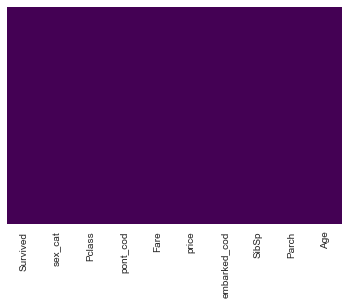

In [42]:
sns.heatmap(df_age_x.isnull(), yticklabels=False,cbar=False,cmap='viridis')

<AxesSubplot:>

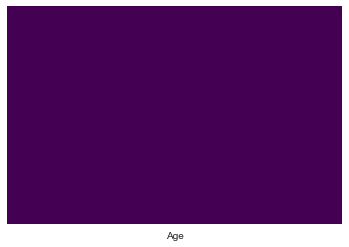

In [43]:
sns.heatmap(df_age_y.isnull(), yticklabels=False,cbar=False,cmap='viridis')

### Estimation de l'âge

In [44]:
age_xtrain, age_xtest, age_ytrain, age_ytest = train_test_split(df_age_x, df_age_y, train_size=0.8)
age_xtrain

,Survived,sex_cat,Pclass,pont_cod,Fare,price,embarked_cod,SibSp,Parch,Age
18,0,1,3,5,7.2500,7.0,2,0,0,21.0
806,0,1,3,5,24.1500,24.0,2,2,0,24.0
422,1,1,2,5,26.0000,26.0,2,1,1,3.0
447,1,1,2,5,10.5000,10.0,2,0,0,62.0
465,0,1,3,5,27.9000,28.0,2,3,2,10.0
...,...,...,...,...,...,...,...,...,...,...
268,1,0,2,3,13.0000,13.0,2,0,0,28.0
147,0,1,3,5,7.8958,8.0,2,0,0,19.0
312,1,0,3,5,7.7500,8.0,1,0,0,22.0
443,1,1,2,5,10.5000,10.0,2,0,0,19.0


In [45]:
def draw_regression2(df, col_x, col_y, col_group=None):
    figure, axe = color_graph_background(1,1)

    plt.xlabel(col_x)
    plt.ylabel(col_y)
    # On affiche les données nettoyées
    df.plot.scatter(col_x, col_y, c=col_group, colormap='viridis', ax=axe)

    mini = min(df[col_x])
    maxi = max(df[col_x]) + 1

    X = np.matrix([np.ones(df.shape[0]), df[col_x]]).T
    y = np.matrix(df[col_y]).T
    theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    axe.plot([mini,maxi], [theta.item(0),theta.item(0) + maxi * theta.item(1)], linestyle='--', c='#000000')

    figure.set_size_inches(16, 8, forward=True)
    plt.xticks(rotation=45, ha="right")
    plt.title(col_x + " " + col_y)
    plt.show()

In [46]:
mini = max(df["Age"])
mini

80.0

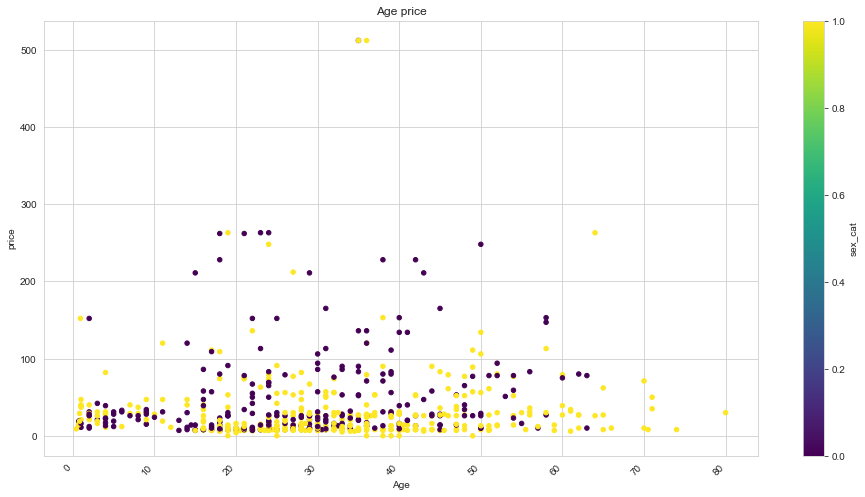

In [50]:
draw_regression2(df_limit, 'Age', 'price', 'sex_cat')

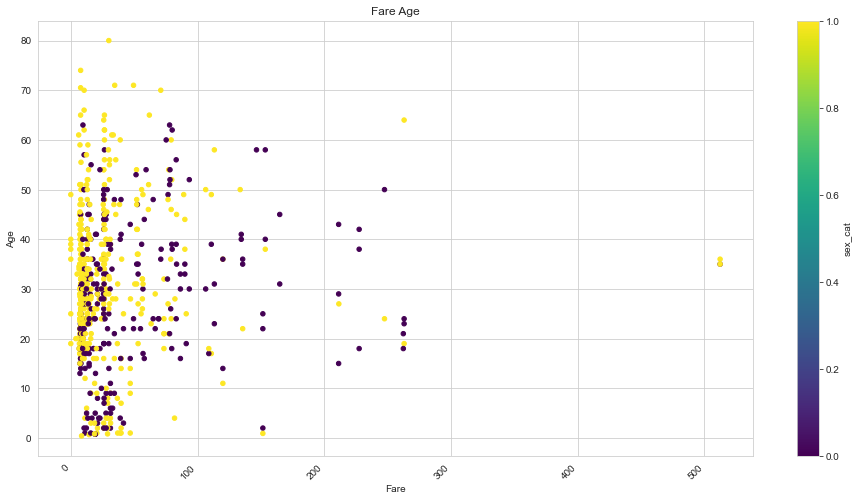

In [51]:
draw_regression2(df_limit, 'Fare', 'Age', 'sex_cat')

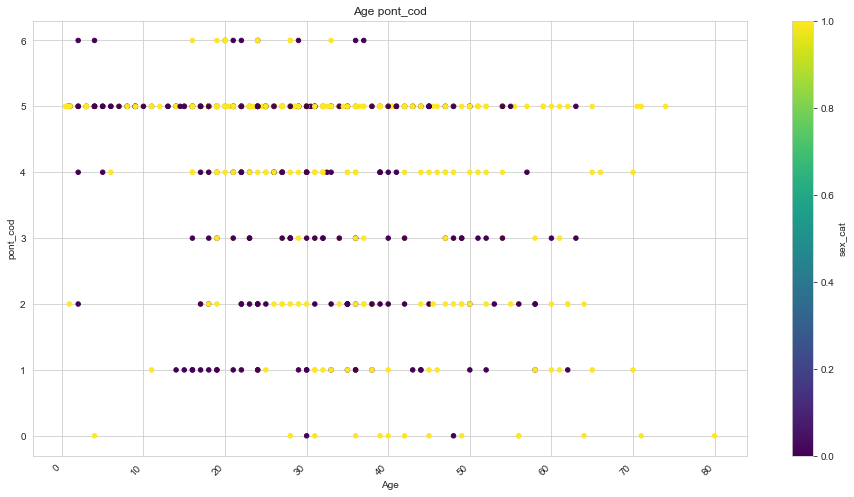

In [52]:
draw_regression2(df_limit, 'Age', 'pont_cod', 'sex_cat')

In [55]:
# x_col = ['Survived', 'sex_cat', 'Pclass', 'pont_cod', 'Fare','price', 'embarked_cod', 'SibSp', 'Parch']
df_temp =df_age_x[['Age', 'price']]
print(df_temp.shape, df_age_y.shape)


(714, 2) (714, 1)


In [59]:
def draw_regression_3d(df, col_x, col_y, col_hue, col_group=None):  
    fig = plt.figure(figsize=(16, 8)).gca(projection='3d')

    # Pour faciliter la visualisation, on va changer la valeur de l'arrondissement (10)
    tmp_arr = df[col_hue][:]
    if col_group is None:
        fig.scatter(tmp_arr, df[col_x], df[col_y], c=tmp_arr, cmap="viridis")
    else:
        fig.scatter(tmp_arr, df[col_x], df[col_y], c=df[col_group], cmap="viridis")
 
    plt.xlabel(col_hue)
    plt.ylabel(col_x)
    plt.xticks(rotation=45, ha="right")
    plt.title(col_x + " " + col_y + " "+col_hue)
    plt.show()

In [ ]:
def draw_regression_3d(df, col_x, col_y, col_hue, col_group=None): 
    fig = plt.figure(figsize=(16, 8)).gca(projection='3d')
    fig = plt.figure(figsize=(16, 8)).gca(projection='3d')
    # Pour faciliter la visualisation, on va changer la valeur de l'arrondissement (10)
    tmp_arr = df[col_hue][:]
    if col_group is None:
        fig.scatter(tmp_arr, df[col_x], df[col_y], c=tmp_arr, cmap="viridis")
    else:
        fig.scatter(tmp_arr, df[col_x], df[col_y], c=df[col_group], cmap="viridis")
 
    plt.xlabel(col_hue)
    plt.ylabel(col_x)
    plt.xticks(rotation=45, ha="right")
    plt.title(col_x + " " + col_y)
    plt.show()

In [61]:
# age_xtrain, age_xtest, age_ytrain, age_ytest 
sns.regplot(age_xtrain, age_ytrain)

C:\Program Files\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


ValueError: regplot inputs must be 1d

C:\Users\User\AppData\Local\Temp/ipykernel_21252/3875028944.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  fig = figure.gca(projection='3d')


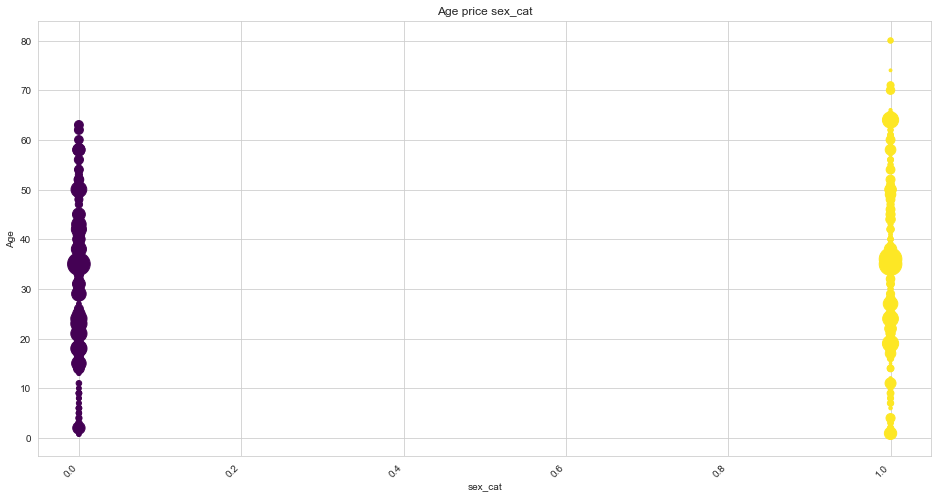

In [60]:
draw_regression_3d(df_limit, 'Age', "price", "sex_cat")

C:\Users\User\AppData\Local\Temp/ipykernel_3564/1660237694.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  fig = plt.figure(figsize=(16, 8)).gca(projection='3d')


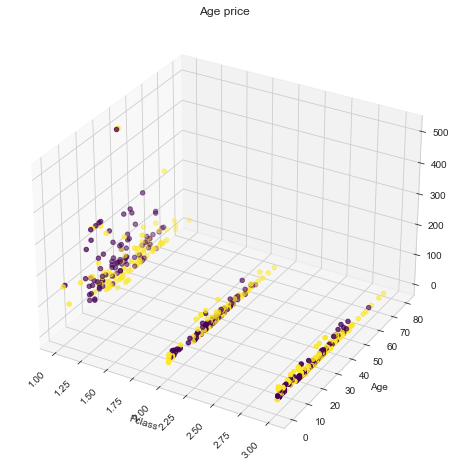

In [ ]:
# x_col = ['Survived', 'sex_cat', 'Pclass', 'pont_cod', 'Fare','price', 'embarked_cod', 'SibSp', 'Parch']
draw_regression_3d(df,  'Age',"price", "Pclass", "sex_cat")

In [300]:
import statsmodels.formula.api as smf


ModuleNotFoundError: No module named 'statsmodels'

In [231]:
A = np.vstack(df_age_x[['sex_cat', 'price']]).T
m, c = np.linalg.lstsq(A, df_age_y, rcond=None)

LinAlgError: Incompatible dimensions

In [ ]:
import matplotlib.pyplot as plt

_ = plt.plot(x, y, 'o', label='Original data', markersize=10)

_ = plt.plot(x, m*x + c, 'r', label='Fitted line')

_ = plt.legend()

plt.show()

solver{‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’

    Algorithm to use in the optimization problem. Default is ‘lbfgs’. To choose a solver, you might want to consider the following aspects:
* For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones;
* For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss;
* ‘liblinear’ is limited to one-versus-rest schemes.

In [73]:
from sklearn.linear_model import LogisticRegression
# logit = LogisticRegression(solver='liblinear')   # ValueError: Unknown label type: 'continuous'
# logit = LogisticRegression(solver='newton-cg')   # ValueError: Unknown label type: 'continuous'
logit = LogisticRegression(solver='lbfgs')   # ValueError: Unknown label type: 'continuous'
logit.fit(age_xtrain,age_ytrain)

C:\Program Files\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: Unknown label type: 'continuous'

In [ ]:
y_pred = logit.predict(X_test)

<mark>Faire une régression linéaire pour estimer l'âge pour les données manquantes</mark>    
par rapport à la classe, au billet, ....

Compléter les cabines pour les valeurs manquantes


De nombreuses valeurs manquantes parsèment le jeu de données.
Le nombre sur **Cabin** peut potentiellement facilement s'expliquer assez facilement : cela correspond pour une grande partie à des individus qui n'avaient simplement pas de cabine. En effet seuls les passagers de 1ère classe et certains de 2ème disposaient d'un numéro de cabine pour leur voyage.

Ces cabines étaient répartis entre les ponts A et E pour les 1ère classe, et de D à G pour les autres.
La cabine T est une cabine de classe supérieure située sur le pont A.

Si on observe rapidement la variable Cabin, on peut noter que le première caractère correspond au pont en question. On extrait donc ce dernier et on analyse la répartition des classes au sein des valeurs manquantes sur notre pont.

**Supprimer les variables 'PassengerId','Name','SibSp','Parch', 'Ticket', 'Fare', 'Embarked'**

Vérifiez la taille de votre data, supprimer les valeurs manquantes

In [21]:
print("before",df.shape, end="")
df = df.drop(['Name','SibSp','Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],axis=1)
print(" drop col :",df.shape, end="")
df.dropna(subset=['Age', 'Sex'])
print(" drop na :",df.shape)

before (891, 11) drop col : (891, 4) drop na : (891, 4)


In [27]:
df = df.dropna(subset=['Age', 'Sex'])
print(" after",df.shape)

 after (714, 4)


# Exercice

La compétition a été l’occasion de revenir sur ce jeu de données très célèbre, et plusieurs tâches étaient attendues, :
- identifier les facteurs favorisants la survie d'un passager par rapport à un autre, en dressant une typologie des survivants
- créer un algorithme qui pourrait prédire la survie d'un individu à partir de ces caractéristiques.

Vous avez été ajouté à une équipe et le travail et lancé depuis quelques semaines : à cette étape,  la mission est en réalité finie (c.f. le présent notebook). Vos co-équipiers ont travaillé dur : il faut dans un premier temps vous approprier leur travail.

In [28]:
titanic = df[["Survived", "Pclass", "Sex", "Age" ]]
titanic.head()

,Survived,Pclass,Sex,Age
PassengerId,,,,
1,0,3,male,22.0
2,1,1,female,38.0
3,1,3,female,26.0
4,1,1,female,35.0
5,0,3,male,35.0


In [29]:
titanic["Sex"].replace(["male", "female"], [0,1], inplace=True)
titanic.head()

,Survived,Pclass,Sex,Age
PassengerId,,,,
1,0,3,0,22.0
2,1,1,1,38.0
3,1,3,1,26.0
4,1,1,1,35.0
5,0,3,0,35.0


In [30]:
titanic.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
dtype: int64

In [41]:
model = KNeighborsClassifier(n_neighbors=1)

In [42]:
y = titanic["Survived"]
x = titanic.drop("Survived", axis=1)
print(y.head())
x.head()

PassengerId
1    0
2    1
3    1
4    1
5    0
Name: Survived, dtype: int64


,Pclass,Sex,Age
PassengerId,,,
1,3,0,22.0
2,1,1,38.0
3,3,1,26.0
4,1,1,35.0
5,3,0,35.0


In [43]:
model.fit(x, y)
model.score(x,y)

0.8739495798319328

In [44]:

def survie(model, pclass=3, sex=1, age=40):
    x = np.array([pclass, sex, age]).reshape(1, 3)
    print(model.predict(x))
    print(model.predict_proba(x))

In [45]:
survie(model, 3, 1, 40)

[0]
[[1. 0.]]


C:\Program Files\Python39\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Program Files\Python39\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [39]:
# tester entre 0 et 10

def found_better_neigbors(x, y):
    better_score = 0
    better_n=0
    for i in range (1, 10):
        model = KNeighborsClassifier(n_neighbors=i) 
        model.fit(x, y)
        res = model.score(x,y)
        if res > better_score:
            better_score = res
            better_n = i
    print(f"Avec un score de {better_score}, le meilleur paramètre est {better_n}")
    return better_n

In [40]:
found_better_neigbors(x, y)

Avec un score de 0.8739495798319328, le meilleur paramètre est 1


1